In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import find_peaks
import cv2
from datetime import date
%matplotlib notebook

# Input data from the arduino

In [2]:
def read_arduino(ser,inputBufferSize):
    data = ser.read(inputBufferSize)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            # Found beginning of frame
            # Extract one sample from 2 bytes
            intout = (np.bitwise_and(data_in[i],127))*128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result,intout)
        i=i+1
    return result

# Initialize the comport

In [3]:
baudrate = 230400
cport = 'COM3'
ser = serial.Serial(port=cport, baudrate=baudrate)

# The classifier to classify events (Kathy Huang)

In [4]:
def classifier(data_t,base_threshold,peak_threshold,l_sigma,r_sigma,b_sigma,flipped=False):
    
    """Determines what event is seen in the signal"""
    
    total = 0

    threshold_check_L =l_sigma
    threshold_check_R = r_sigma
    threshold_check_B = b_sigma

    #classifier
    Y_stream = data_t
    result = []
    event_x_graph = []
    predicted = []
    found_event = ""
    base = True
    base_counter = 0
    DB_peak = False
    peak = 0
    index = []
    
    for i in range(len(Y_stream)):
        if base:
            if (Y_stream[i] > threshold_check_B):
                
                if (Y_stream[i] > Y_stream[i + 1]) & (Y_stream[i] > Y_stream[i - 1]):
                    if Y_stream[i] > threshold_check_L:
                        found_event = "L"
                        base = False
                    if Y_stream[i] <= threshold_check_L:
                        DB_peak = True
                        base = False
                
            if Y_stream[i] < threshold_check_R:
                found_event = "R"
                base = False
                
        if DB_peak:
            if (Y_stream[i] > Y_stream[i + 1]) & (Y_stream[i] > Y_stream[i - 1]):
                if (peak <= peak_threshold):
                    found_event = "DB"
                    base = False
                    peak = 0
            else: 
                peak += 1
                
        if not base:
            if (Y_stream[i] > threshold_check_B) | (Y_stream[i] < threshold_check_R) : 
                if found_event != "":
                    predicted.append(found_event)
                    found_event = ""
                    index.append(i)
                    DB_peak = False

            if base_counter >= base_threshold:
                base = True
                base_counter = 0

            elif (Y_stream[i] <= threshold_check_B) & (Y_stream[i] >= threshold_check_R):
                base_counter += 1

            else: 
                base_counter = 0
                
    result.append(predicted)
    event_x_graph.append(index)

    return result, event_x_graph


# Camera  Keybindings (Sahir Nagpal, Oliver Ashton)

In [5]:
def camera(event,image,scale,img_counter = 0):
    
    """Keybindings of the camera to camera operations"""
    
    #get the webcam size
        height, width, channels = image.shape
        
        #prepare the crop
        centerX,centerY=int(height/2),int(width/2)
        radiusX,radiusY= int(scale*height/100),int(scale*width/100)

        minX,maxX=centerX-radiusX,centerX+radiusX
        minY,maxY=centerY-radiusY,centerY+radiusY

        frame = image[minX:maxX, minY:maxY]
        frame = cv2.resize(frame, (width, height))

        cv2.imshow('my webcam', frame)

        if event == 'L' and scale>=5:
            if scale ==5:
                scale = 10
            print("Zooming in")
            scale -= 5  # -5
        
        elif event == 'R'and scale<=55:
            if scale == 55:
                scale = 50
            print("Zooming Out")
            scale += 5  # +5
             
        elif event == 'DB':
            time.sleep(0.3) # Used because of bad FPS camera
            cv2.imshow('my webcam', frame)
            img_name = "Pics/{}_{}.png".format(str(today),img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))    
            img_counter += 1
        
        elif event == '':
            pass
            
        return frame,scale,img_counter,width,height

# Bandpass Filter (Sahir Nagpal, Oliver Ashton)

In [6]:
def fftplot(data,fs,zoom = 350,cutlow=0,cuthigh=20):

    """Implements bandpass filters"""
    
#   Defining time domain and taking the FFT
    df = fs/len(data)
    t = np.linspace(0,len(data)/fs,len(data))
    
#   Getting the frequencies and getting rid frequencies above cuthigh and below cutlow
    freq, amp = spectrum(t,data)
    amp = steplow(cutlow,freq,amp) 
    amp = stephigh(cuthigh,freq,amp)
    
#   Getting the wave after clearing the data
    Y = np.fft.irfft(amp)
    
#   Zooming the frequency graph
    if zoom == None:
        cutfreq = freq
        cutamp = amp
        t1 = t
    else:
        cutfreq = freq[0:zoom]
        cutamp = amp[0:zoom]
        t1 = t[0:zoom]

    cutamp = np.abs(cutamp)**2
        
    return Y,cutfreq[np.argmax(cutamp)]


# Live Streaming (Sahir Nagpal, Oliver Ashton)

<IPython.core.display.Javascript object>


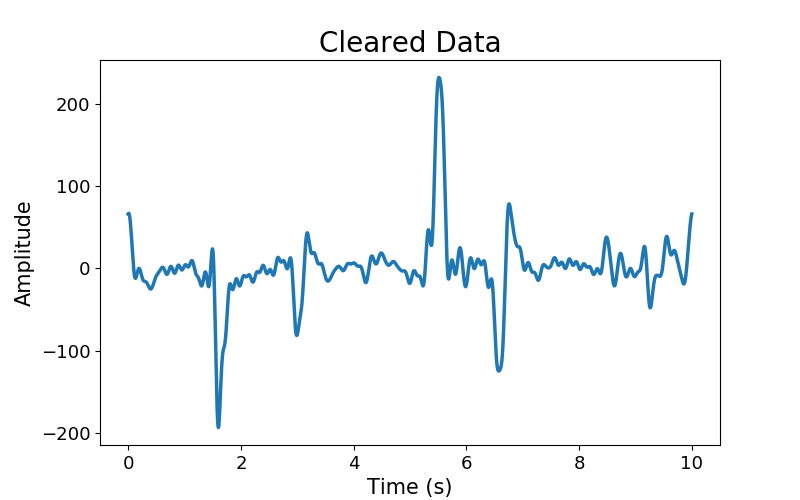

[[]] - [[]]
[[]] - [[]]
[[]] - [[]]
[[]] - [[]]
[[]] - [[]]
[[]] - [[]]
[[]] - [[]]
[[]] - [[]]
[[]] - [[]]
[[]] - [[]]
[[]] - [[]]
Pics/2020-05-25_0.png written!
[['DB']] - [[30738]]
[['DB']] - [[30927]]
[['DB']] - [[30923]]
[['DB']] - [[30923]]
[['DB']] - [[30926]]
[['DB']] - [[30924]]
[['DB']] - [[30926]]
[['DB']] - [[30924]]
[['DB']] - [[30924]]
Zooming in
[['DB', 'L']] - [[30932, 54432]]
[['DB', 'L']] - [[30924, 54821]]
[['DB', 'L']] - [[30926, 54814]]
[['DB', 'L']] - [[30928, 54817]]
[['DB', 'L']] - [[30927, 54816]]
[['DB', 'L']] - [[30929, 54817]]
[['DB', 'L']] - [[30929, 54818]]
Zooming Out
[['DB', 'L', 'R']] - [[30917, 54807, 70700]]
[['DB', 'L', 'R']] - [[30932, 54821, 70696]]
[['DB', 'L', 'R']] - [[30930, 54819, 70689]]
[['DB', 'L', 'R']] - [[30929, 54819, 70688]]
[['DB', 'L', 'R']] - [[30931, 54820, 70687]]
[['DB', 'L', 'R']] - [[30930, 54820, 70688]]
[['DB', 'L', 'R']] - [[30929, 54819, 70688]]
Pics/2020-05-25_1.png written!
[['DB', 'L', 'R', 'DB']] - [[30922, 54813, 70683

IndexError: index 102370 is out of bounds for axis 0 with size 102370

In [7]:
#Data time
%matplotlib notebook
inputBufferSize = 5000
ser.timeout = inputBufferSize/20000.0  # set read timeout, 20000 is one second
ser.set_buffer_size(rx_size = inputBufferSize)

total_time = 10.0; # time in seconds [[1 s = 20000 buffer size]]
max_time = 10.0; # time plotted in window [s]
N_loops = 20000.0/inputBufferSize*total_time

T_acquire = inputBufferSize/20000.0    # length of time that data is acquired for 
N_max_loops = max_time/T_acquire    # total number of loops to cover desire time window

l = 0
threshold = 1
fs = 10000
store = []
time_store=[]
event=[]
cuthigh = 8
l = 130
r = -120
db = 45
base = 3000
k=0
peak_threshold = 5000

scale= 30
today = date.today()
img_counter=0

fig, ax = plt.subplots(1,1,figsize=(8,5))
cam = cv2.VideoCapture(0)
while True:
    ret_val, image = cam.read()
    data = read_arduino(ser,inputBufferSize)
    data_temp = process_data(data)
    
    if k <= N_max_loops:
        if k==0:
            data_plot = data_temp
            Y,dude = fftplot(data_plot, fs, zoom = 350,cutlow=0,cuthigh=cuthigh)

        else:
            data_plot = np.append(data_plot,data_temp)
            Y,dude = fftplot(data_plot,fs,zoom = 350,cutlow=0,cuthigh=cuthigh)
        t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)

    else:
        data_plot = np.roll(data_plot,-len(data_temp))
        data_plot[0:len(data_temp)] = data_temp
        Y,dude = fftplot(data_plot,fs,zoom = 350,cutlow=0,cuthigh=cuthigh)
    k+=1
    t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    Y_clear,dude =  fftplot(data_temp,fs,zoom = 350,cutlow=0,cuthigh=cuthigh)
    
    key = cv2.waitKey(1)
    
    if key == 27: # Press esc to quit
        print("Closing Camera")
        cv2.destroyAllWindows()
        break  
        
    if len(data_plot)>5000: # To omit the misbehaving signals that the spiker bo gives atg the start of the live stream (See group report)
        event,event_time = classifier(prev_Y,base_threshold = base,peak_threshold= peak_threshold,l_sigma = l,r_sigma=r,b_sigma=db)
        store.append(event)
        time_store.append(event_time)
        
    if event!=[[]] and len(event)>0 and prev!=event and len(data_plot)>7000:
        image,scale,img_counter,w,h = camera(event[-1][-1],image,scale,img_counter)
    else:
        image,scale,img_counter,w,h = camera('',image,scale,img_counter)
    
    prev = event
    prev_Y = Y
    # Cleared Data
    ax.clear()
    ax.plot(t[0:len(Y)],Y,linewidth=2.5)
    ax.set_xlabel('Time (s)',fontsize=15)
    ax.set_ylabel('Amplitude',fontsize=15)
    ax.set_title('Cleared Data',fontsize=20)
    ax.tick_params(axis='both',labelsize=13)

    #Events
    if len(store)>0:
        print(event, "-", event_time)
    fig.canvas.draw()
    plt.show()

fig.show()
fig.canvas.draw()